<a href="https://colab.research.google.com/github/Hajara-Waseem/LAB-TASK-10_DiP/blob/main/TASK_10_DIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import files

# This will open a file picker dialog to let you select and upload files.
uploaded = files.upload()

for filename in uploaded.keys():
  print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

Saving bowsprit_daisy_1_559463.jpg to bowsprit_daisy_1_559463.jpg
User uploaded file "bowsprit_daisy_1_559463.jpg" with length 28156 bytes


First, let's load the image, convert it to grayscale, and display it. Huffman coding is typically applied to grayscale images for simplicity or to each channel of a color image separately.

Original image shape: (388, 582)
Original image size: 225816 bytes (assuming 1 byte per pixel)


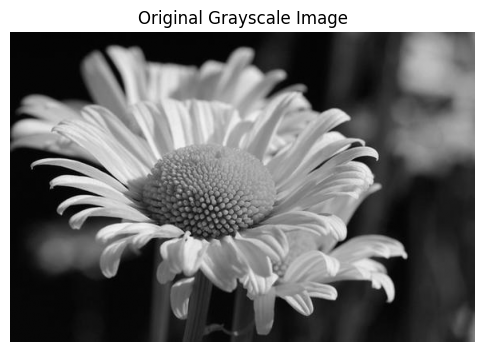

In [3]:
image_path = filename # 'filename' is available from the previous upload cell

# Read the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    print(f"Error: Could not load image from {image_path}")
else:
    print(f"Original image shape: {img.shape}")
    print(f"Original image size: {img.size} bytes (assuming 1 byte per pixel)")

    # Display the original grayscale image
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title('Original Grayscale Image')
    plt.axis('off')
    plt.show()

Next, we'll implement the Huffman Coding algorithm. This involves:
1.  Calculating the frequency of each pixel value.
2.  Building a Huffman tree from these frequencies.
3.  Generating Huffman codes (bit strings) for each pixel value.
4.  Encoding the image using these codes.
5.  Decoding the image back to its original form.

Number of unique pixel values: 244
Encoded data length (bits): 1684610
Original size: 1806528 bits
Compressed size: 1684610 bits
Compression Ratio: 1.07:1


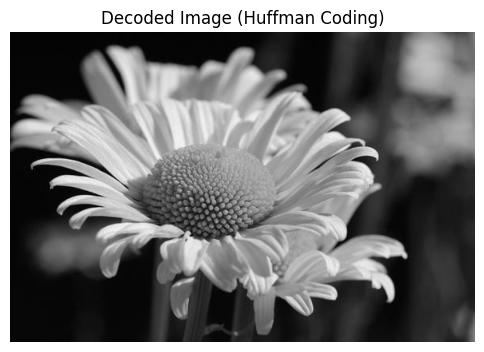

Decoding successful: Original and decoded images are identical.


In [4]:
import heapq
from collections import defaultdict

# 1. Calculate frequency of pixel values
def calculate_frequencies(image_array):
    frequencies = defaultdict(int)
    for pixel in image_array.flatten():
        frequencies[pixel] += 1
    return frequencies

# Define a Node class for the Huffman tree
class Node:
    def __init__(self, char, freq, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left
        self.right = right

    # Used for heapq comparison
    def __lt__(self, other):
        return self.freq < other.freq

# 2. Build the Huffman Tree
def build_huffman_tree(frequencies):
    priority_queue = [Node(char, freq) for char, freq in frequencies.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        merged = Node(None, left.freq + right.freq, left, right)
        heapq.heappush(priority_queue, merged)
    return priority_queue[0]

# 3. Generate Huffman Codes
def generate_huffman_codes(node, current_code="", codes=None):
    if codes is None:
        codes = {}
    if node.char is not None:
        codes[node.char] = current_code
        return
    if node.left:
        generate_huffman_codes(node.left, current_code + "0", codes)
    if node.right:
        generate_huffman_codes(node.right, current_code + "1", codes)
    return codes

# 4. Encode the image
def encode_image(image_array, huffman_codes):
    encoded_data = ""
    for pixel in image_array.flatten():
        encoded_data += huffman_codes[pixel]
    return encoded_data

# 5. Decode the image
def decode_image(encoded_data, huffman_tree_root, original_shape):
    decoded_pixels = []
    current_node = huffman_tree_root
    for bit in encoded_data:
        if bit == '0':
            current_node = current_node.left
        else:
            current_node = current_node.right

        if current_node.char is not None:
            decoded_pixels.append(current_node.char)
            current_node = huffman_tree_root

    # Convert list of pixels back to numpy array with original shape
    return np.array(decoded_pixels, dtype=np.uint8).reshape(original_shape)


# --- Apply Huffman Coding to the image ---
if img is not None:
    # Step 1: Calculate frequencies
    frequencies = calculate_frequencies(img)
    print(f"Number of unique pixel values: {len(frequencies)}")

    # Step 2: Build Huffman tree
    huffman_tree_root = build_huffman_tree(frequencies)

    # Step 3: Generate Huffman codes
    huffman_codes = generate_huffman_codes(huffman_tree_root)
    # print("Huffman Codes:", huffman_codes) # Uncomment to see codes

    # Step 4: Encode the image
    encoded_image_data = encode_image(img, huffman_codes)
    print(f"Encoded data length (bits): {len(encoded_image_data)}")

    # Step 5: Decode the image
    decoded_img = decode_image(encoded_image_data, huffman_tree_root, img.shape)

    # Calculate compression ratio
    original_bits = img.size * 8  # 8 bits per pixel for grayscale
    compressed_bits = len(encoded_image_data)
    compression_ratio = original_bits / compressed_bits
    print(f"Original size: {original_bits} bits")
    print(f"Compressed size: {compressed_bits} bits")
    print(f"Compression Ratio: {compression_ratio:.2f}:1")

    # Display the decoded image
    plt.figure(figsize=(6, 6))
    plt.imshow(decoded_img, cmap='gray')
    plt.title('Decoded Image (Huffman Coding)')
    plt.axis('off')
    plt.show()

    # Verify if decoded image is identical to original
    if np.array_equal(img, decoded_img):
        print("Decoding successful: Original and decoded images are identical.")
    else:
        print("Warning: Original and decoded images are NOT identical. There might be an issue.")

For JPEG-like compression, we'll perform the following steps:
1.  **Image Preparation**: Convert the grayscale image to float32 and shift pixel values by -128.
2.  **DCT and Quantization**: Divide the image into 8x8 blocks, apply DCT, and then quantize the coefficients using a simple quantization matrix.
3.  **Dequantization and IDCT**: Dequantize the coefficients, apply Inverse DCT (IDCT), and shift pixel values back by +128.
4.  **Reconstruction**: Reconstruct the image from the processed blocks.

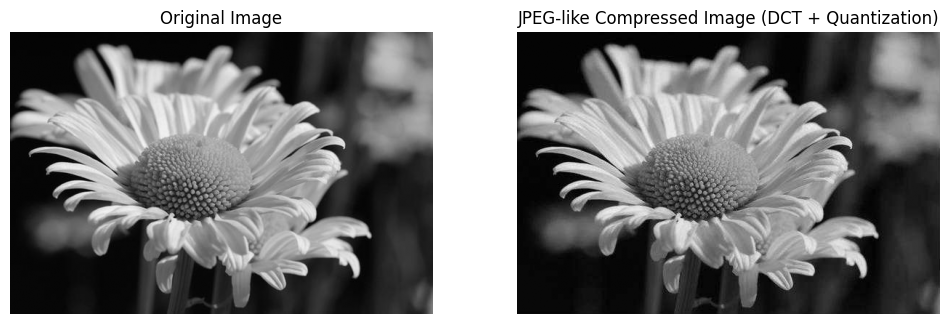

Mean Squared Error (MSE): 9.78
Peak Signal-to-Noise Ratio (PSNR): 38.23 dB


In [6]:
# Ensure the image is loaded and is grayscale
if img is None:
    print("Error: Image 'img' is not loaded. Please run the previous cells first.")
else:
    # Step 1: Image Preparation
    # Convert to float32 and shift values by -128
    img_float = np.float32(img) - 128

    # Define a simple 8x8 quantization matrix (example, not standard JPEG)
    # In real JPEG, this matrix is usually more sophisticated
    quantization_matrix = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    # Image dimensions
    h, w = img_float.shape

    # Calculate padding needed to make dimensions multiples of 8
    h_pad = (8 - h % 8) % 8
    w_pad = (8 - w % 8) % 8

    # Pad the image
    img_padded = np.pad(img_float, ((0, h_pad), (0, w_pad)), 'constant', constant_values=0)

    # Update dimensions to padded dimensions for iteration
    h_processed, w_processed = img_padded.shape

    # Create an empty array to store the reconstructed image (padded size)
    compressed_img_padded = np.zeros_like(img_padded)

    # Iterate over 8x8 blocks
    for i in range(0, h_processed, 8):
        for j in range(0, w_processed, 8):
            # Extract 8x8 block from padded image
            block = img_padded[i:i+8, j:j+8]

            # Step 2: Apply DCT and Quantization
            dct_block = cv2.dct(block)
            quantized_block = np.round(dct_block / quantization_matrix)

            # Step 3: Dequantization and IDCT
            dequantized_block = quantized_block * quantization_matrix
            idct_block = cv2.idct(dequantized_block)

            # Step 4: Reconstruction (shift back +128 and clip to 0-255)
            compressed_img_padded[i:i+8, j:j+8] = np.clip(idct_block + 128, 0, 255)

    # Crop the compressed image back to original dimensions
    compressed_img = compressed_img_padded[0:h, 0:w]

    # Convert back to uint8 for display
    compressed_img_uint8 = np.uint8(compressed_img)

    # Display the compressed image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(compressed_img_uint8, cmap='gray')
    plt.title('JPEG-like Compressed Image (DCT + Quantization)')
    plt.axis('off')
    plt.show()

    # Calculate PSNR as a quality metric
    mse = np.mean((img - compressed_img_uint8) ** 2)
    if mse == 0:
        psnr = "Infinity" # Perfect match
    else:
        max_pixel = 255.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")

In [7]:
print(f"--- Compression Metrics ---")
print(f"Huffman Coding Compression Ratio (CR): {compression_ratio:.2f}:1")
print(f"JPEG-like Compression MSE: {mse:.2f}")
print(f"JPEG-like Compression PSNR: {psnr:.2f} dB")

--- Compression Metrics ---
Huffman Coding Compression Ratio (CR): 1.07:1
JPEG-like Compression MSE: 9.78
JPEG-like Compression PSNR: 38.23 dB


### Understanding Rate Distortion (RD)

Rate Distortion (RD) theory provides a mathematical framework for balancing the bit rate (number of bits used to represent data) with the amount of distortion (loss of information) introduced during compression. It's usually represented as a **Rate-Distortion curve** or function, R(D), which shows the minimum achievable bit rate for a given distortion D, or D(R), the minimum distortion for a given bit rate R.

Unlike CR, MSE, or PSNR, which are single point metrics, an RD curve illustrates the trade-off. To generate an RD curve for an image compression algorithm, you would typically:

1.  **Vary a compression parameter**: For JPEG-like compression, this could be the quantization matrix (e.g., using different quality factors).
2.  **For each parameter setting**: Encode and decode the image.
3.  **Calculate the Rate**: Determine the actual bit rate of the compressed image (e.g., bits per pixel, or total compressed size).
4.  **Calculate the Distortion**: Measure the distortion between the original and reconstructed image (e.g., MSE or PSNR).
5.  **Plot the results**: Plot the rate against the distortion to visualize the trade-off.

### Visual Comparison: Original vs. JPEG-like Compressed Image

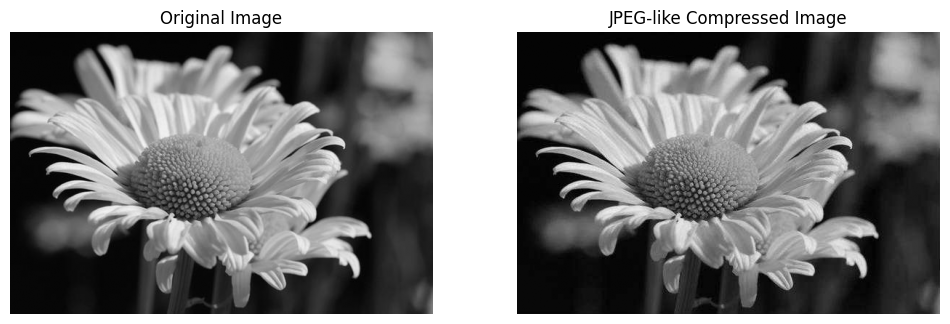

In [8]:
if img is not None and 'compressed_img_uint8' in locals():
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(compressed_img_uint8, cmap='gray')
    plt.title('JPEG-like Compressed Image')
    plt.axis('off')
    plt.show()
else:
    print("Original image (img) or compressed image (compressed_img_uint8) not found. Please run previous cells.")

### Quantitative Comparison: Huffman vs. JPEG-like Compression Metrics

In [9]:
print(f"--- Huffman Coding ---")
print(f"Compression Ratio (CR): {compression_ratio:.2f}:1\n")

print(f"--- JPEG-like Compression ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")

--- Huffman Coding ---
Compression Ratio (CR): 1.07:1

--- JPEG-like Compression ---
Mean Squared Error (MSE): 9.78
Peak Signal-to-Noise Ratio (PSNR): 38.23 dB
